In [1]:
import time #to wait between requests and be polite :)
from tqdm import tqdm

# Open question:

We want to determine how much the popularity value of an artist in spotify is determined by connection with other popular artists. Or maybe other patterns? We'll make some hypothesis and attempt to evaluate.

Hypotheses, collaborations between artists boost the popularity of one artist.

How do we aim to prove that? Get a graph where node values are the popularity score of an artist and edge weight the number of collaborations they have together.
Then measure correlation between edge weights and node values and also with centrality metrics.

We'll start by reusing the crawler from the first lab and modifying it.
Note that to know if two artist have had a collaboration, there is no spotify api method for that but rather we have to look at each song for that artist.

In [10]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import networkx as nx
CLIENT_ID = "eba5add1acc4485dac617d5c357d5185"
CLIENT_SECRET ="52d4c70893034d3cae8f42595e798fa9"
auth_manager = SpotifyClientCredentials(
client_id=CLIENT_ID ,
client_secret=CLIENT_SECRET)
sp = spotipy.Spotify(auth_manager=auth_manager)

In [11]:
def search_artist(artist_name: str) -> str:
    """
    Search for an artist in Spotify.

    :param artist_name: name to search for.
    :return: spotify artist id.
    """
    # ------- IMPLEMENT HERE THE BODY OF THE FUNCTION ------- #
    return sp.search(artist_name,type="artist",limit=1)["artists"]["items"][0]["id"]
    # ----------------- END OF FUNCTION --------------------- #

In [12]:
VARIOUS_ARTIST_ID = "0LyfQWJT6nXafLPZqxe9Of"
def get_collaborating_artists(artist_id):
    """
    Given an artist id returns a list of tuples containing edges for a graph
    where the edge weight is the number of album collaborations between two artists.
    """
    #some values that we'll use further on
    durations = 0
    explicits = 0
    n_tracks = 0 

    results =  sp.artist_albums(artist_id,limit=50,country="ES")#maximum of albums to get is 50
    albums_ids = [alb["id"] for alb in results["items"]]
    
    colabos = {}
    for album_id in tqdm(albums_ids):  #init colabos dictionary
        #get all tracks for that album
        tracks = sp.album_tracks(album_id,limit=50)["items"]
        n_tracks += len(tracks)
        for tk in tracks:
            durations += tk["duration_ms"]
            if tk["explicit"]:
                explicits += 1
            #check for colabos
            if len(tk['artists']) > 1:
                for at in tk["artists"]:
                    if at["id"] != artist_id:
                        #check if key exists in colabos dict
                        gette = colabos.get(at["id"])
                        if gette is not None: #if not None
                            colabos[at["id"]] += 1

                        else: #set value to that key and create key in the process
                            colabos[at["id"]] = 1
                            
    #convert this to a list of tuples for our graph.
    tograph = []
    for art_id,n_colabos in zip(colabos.keys(),colabos.values()):
        tograph.append((artist_id,art_id,n_colabos))

    return tograph, (durations, explicits, n_tracks)

In [13]:
def crawler(seed: str, max_nodes_to_crawl: int, strategy: str = "BFS", out_filename: str = "g.graphml",return_last_cr = False) -> nx.DiGraph:
    """
    Crawl the Spotify artist graph, following related artists.

    :param seed: starting artist id.
    :param max_nodes_to_crawl: maximum number of nodes to crawl.
    :param strategy: BFS or DFS.
    :param out_filename: name of the graphml output file.
    :return: networkx directed graph.
    """
    # ------- IMPLEMENT HERE THE BODY OF THE FUNCTION ------- #
    G = nx.DiGraph()
    
    current_seed = seed
    crawled = [] 
    tocrawl = []
    tocrawl_aux = []
    
    #cnt = 0
    for i in tqdm(range(max_nodes_to_crawl)):
        #cnt += 1
        #sleep one second to be polite to the spotify API.
        #print(tocrawl_aux)
        
        #first crawl
        #get colabo artist from seed artist
        try:
            colabos_edges, (durations, explicits, n_tracks) = get_collaborating_artists(current_seed)
        except:
            print("Spotify api reached max xd, finishing crawling")
            break
        
        crawled.append(current_seed) 
        """
        #instead of exploring artist with collabo search for related
        found = sp.artist_related_artists(current_seed)
        found_ids = [art["id"] for art in found["artists"]] #get found artists ids
        """
        found_ids = [colb_at for _,colb_at,_ in colabos_edges] #get found artists ids

        #Add edges to graph:
        G.add_weighted_edges_from(colabos_edges) #add found edges and new nodes to graph
        
        if strategy == "BFS":
            tocrawl = tocrawl + found_ids #add new nodes to tocrawl pile mantaining BFS priority
            #tocrawl_aux += [cnt]*len(not_crawled)
            
        elif strategy == "DFS":            
            tocrawl = found_ids + tocrawl #add new nodes to tocrawl pile mantaining DFS priority
            #tocrawl_aux  = [cnt]*len(not_crawled) + tocrawl_aux

        if(len(tocrawl) == 0):
            print("Cannot crawl further")
            break
        
        current_seed = tocrawl[0]
        tocrawl = tocrawl[1:]
        #tocrawl_aux.remove(tocrawl_aux[0])
        while current_seed in crawled: #in case the node we are about to crawl has aleady been crawled
            #print("Node already crawled, next...")
            current_seed = tocrawl[0]
            tocrawl = tocrawl[1:]
            #tocrawl_aux.remove(tocrawl_aux[0])
    
    #finally set nodes attributes, the spotify popularity value and more... 

    #we do requests in batches so we have less requests, spotify lets us 
    #request up to 50 artists at a time
    all_batches = []
    for nd in G.nodes:
        batch_artists = []
        while len(batch_artists) < 50:
            batch_artists.append(nd)
        all_batches.append(batch_artists)

    attributes = {}
    for artists_batch in all_batches:
        artists = sp.artists(artists_batch)["artists"]
        for at in artists:
            gnres = ""
            for g in at["genres"]:
                gnres += " '" + g +"'"
            
            attributes[at["id"]] = {"n_follows":at["followers"]["total"],"genres":gnres,"name":at["name"],"popularity":at["popularity"]}
            if at["id"] == current_seed: #add extra info to crawled node
                attributes[at["id"]]["durations"] = durations
                attributes[at["id"]]["explicits"] = explicits
                attributes[at["id"]]["n_tracks"] = n_tracks


    nx.set_node_attributes(G, attributes)
    
    #save graph to file
    nx.write_graphml(G,out_filename)
    
    #depending on the output mode
    if return_last_cr:
        return G, crawled[-1]
    
    return G

In [14]:
id = search_artist("Susi abanades")

In [15]:
id

'0e74JQnC17wREL7VkgfKQR'

In [16]:
NODES_TO_CRAWL = 100

In [17]:
colabos_graph = crawler(id, max_nodes_to_crawl=NODES_TO_CRAWL, strategy= "BFS", out_filename= "colabos.graphml")

  0%|          | 0/100 [00:20<?, ?it/s]

Spotify api reached max xd, finishing crawling


In [ ]:
colabos_graph = nx.read_graphml("colabos.graphml")

In [ ]:
colabos_graph.nodes

NodeView(())

In [ ]:
colabos_graph.nodes[id]

KeyError: '0e74JQnC17wREL7VkgfKQR'

Quickly visualize graph:

In [ ]:
import matplotlib.pyplot as plt

Node size based on popularity:

In [ ]:
# Get the maximum edge weight
max_weight = max([weight for _, _, weight in colabos_graph.edges.data("weight")])

# Get the maximum popularity value
max_popularity = max([popularity for _, popularity in colabos_graph.nodes.data("popularity")])

# Define the colormap
colormap = plt.cm.get_cmap("cool")  # Choose a colormap (e.g., "cool", "viridis", "rainbow", etc.)

# Define the mapping function to map edge weights to edge colors
def map_weight_to_color(weight):
    normalized_weight = weight / max_weight
    color = colormap(normalized_weight)
    return color

# Define the mapping function to map edge weights to edge widths
def map_weight_to_width(weight):
    min_width = 1  # Minimum edge width
    max_width = 5  # Maximum edge width
    width = min_width + (max_width - min_width) * (weight / max_weight)
    return width

# Define the mapping function to map popularity to node sizes
def map_popularity_to_size(popularity):
    min_size = 100  # Minimum node size
    max_size = 1000  # Maximum node size
    size = min_size + (max_size - min_size) * (popularity / max_popularity)
    return size

In [ ]:
# Draw the graph with edge widths and colors based on the edge weight
pos = nx.spring_layout(colabos_graph, k=1)  # Layout for node positions
edges = colabos_graph.edges()
weights = [colabos_graph[u][v]['weight'] for u, v in edges]
widths = [map_weight_to_width(weight) for weight in weights]
colors = [map_weight_to_color(weight) for weight in weights]
# Draw nodes with labels and modified node sizes
node_labels = {node: colabos_graph.nodes[node]['name'].replace('$', '') for node in colabos_graph.nodes}
node_sizes = [map_popularity_to_size(popularity) for _, popularity in colabos_graph.nodes.data("popularity")]


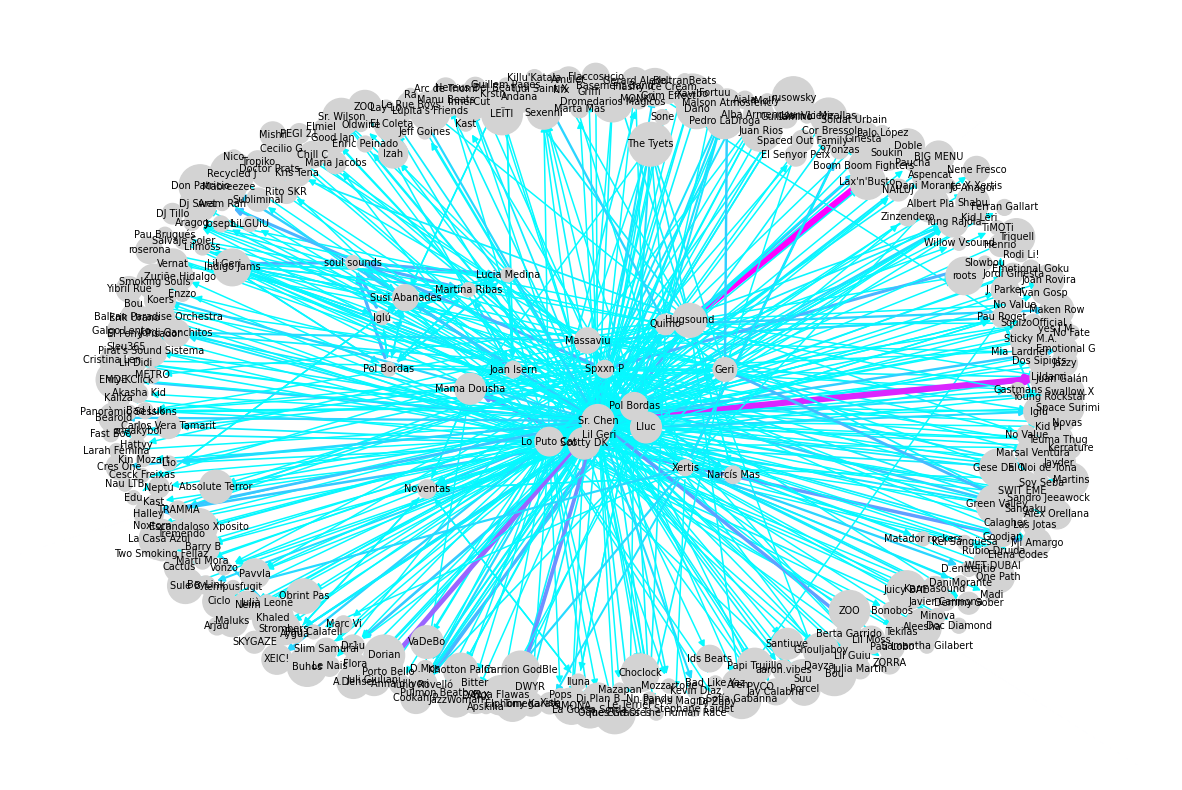

In [ ]:
plt.figure(figsize=(15, 10))
nx.draw_networkx_nodes(colabos_graph, pos, node_color='lightgray', node_size=node_sizes)
nx.draw_networkx_labels(colabos_graph, pos, labels=node_labels, font_size=7)
# Draw edges
nx.draw_networkx_edges(colabos_graph, pos, edgelist=edges, width=widths, edge_color=colors)

# Draw edge labels
#edge_labels = nx.get_edge_attributes(colabos_graph, "weight")
#nx.draw_networkx_edge_labels(colabos_graph, pos, edge_labels=edge_labels)

# Display the graph
plt.axis("off")
plt.show()

Some characteristics of the graph:

In [ ]:
print("Graph size: ",colabos_graph.size())
print("Graph order: ",colabos_graph.order())

Graph size:  600
Graph order:  322


Most of the number of collabos are just 1 album

# Analysis of our data:

Now we want to determine:

Hypothesis 1: More different artists in your albums -> higher popularity (have to check the outdegree)

Hypothesis 2: More different artists in other artists albums -> higher popularity (have to check the indegree)

In [ ]:
popus = [colabos_graph.nodes[node]["popularity"] for node in colabos_graph.nodes]
out_degress = colabos_graph.out_degree()
out_deg_list = [out_degress[node] for node in colabos_graph.nodes]
in_degress = colabos_graph.in_degree()
in_deg_list = [in_degress[node] for node in colabos_graph.nodes]
closeness_cnt = list(nx.closeness_centrality(colabos_graph).values())
betweness_cnt = list(nx.betweenness_centrality(colabos_graph).values())
page_rank = list(nx.pagerank(colabos_graph).values())
in_deg_list = [in_degress[node] for node in colabos_graph.nodes]

In [ ]:
plt.plot(popus[:NODES_TO_CRAWL],label="popularity")
plt.plot(in_deg_list[:NODES_TO_CRAWL],label="in_degree")
plt.plot(out_deg_list[:NODES_TO_CRAWL],label="out_degree")
plt.plot(closeness_cnt[:NODES_TO_CRAWL],label="closensess centr.")
plt.plot(betweness_cnt[:NODES_TO_CRAWL],label="betwennes centr.")
plt.plot(page_rank[:NODES_TO_CRAWL],label="page rank")
plt.legend()
plt.show()


NameError: name 'NODES_TO_CRAWL' is not defined

In [ ]:
import pandas as pd

In [ ]:
len(colabos_graph.nodes)

322

In [ ]:
len(popus)

322

In [ ]:
# Create a dictionary to store node attributes
node_attributes = {}

# Iterate over all nodes in the graph
for node in colabos_graph.nodes:
    # Extract attributes for the current node
    attributes = colabos_graph.nodes[node]
    # Add the attributes to the dictionary
    node_attributes[node] = attributes


# Create a DataFrame from the node attributes dictionary
df = pd.DataFrame.from_dict(node_attributes, orient='index')

# Add columns for the data arrays to the DataFrame
df['popularity'] = popus
df['in_degree'] = in_deg_list
df['out_degree'] = out_deg_list
df['closeness_centr'] = closeness_cnt
df['betweenness_centr'] = betweness_cnt
df['page_rank'] = page_rank

In [ ]:
df

,n_follows,name,popularity,durations,n_tracks,explicits,genres,in_degree,out_degree,closeness_centr,betweenness_centr,page_rank
0e74JQnC17wREL7VkgfKQR,340,Susi Abanades,17,7340147,42,12,NaN,10,10,0.051965,0.029215,0.020828
1PcEYX38hbrPwOfzZmEqEI,986,Pol Bordas,20,7340147,42,12,'trap catala',18,45,0.064273,0.061152,0.014010
0VdA6tRHjufwAJhAhhTpSX,20,Joan Isern,3,7340147,42,12,NaN,8,8,0.036453,0.000058,0.018282
2SMDTYG6dfnugM1u4MQeak,0,Guillem Pagès,0,7340147,42,12,NaN,2,2,0.033457,0.000000,0.003382
3QVT3d3CSkcRK2N6eJCD4N,30,Edu,0,7340147,42,12,NaN,1,1,0.033005,0.000000,0.002938
...,...,...,...,...,...,...,...,...,...,...,...,...
7ACbGJJWT1XbzSXscYb45v,41,DaniMorante,0,7340147,42,12,NaN,1,0,0.027872,0.000000,0.002647
5AKXexlbpSxyfZdKFGOtYQ,17,Parvis Magna,0,7340147,42,12,NaN,1,0,0.027872,0.000000,0.002516
2T7UsUAaUidAzlI5hg2Iiq,8,Rito SKR,11,7340147,42,12,NaN,1,0,0.028478,0.000000,0.002596
68IctVd1EwV3wPTSdlXnK2,77,Kid Lëri,0,7340147,42,12,'trap catala',1,0,0.028478,0.000000,0.002596


/var/folders/j8/64lnvrmj50q5dv_5dj_ztbz40000gn/T/ipykernel_40514/4050515313.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  matrix = df.corr().round(2)


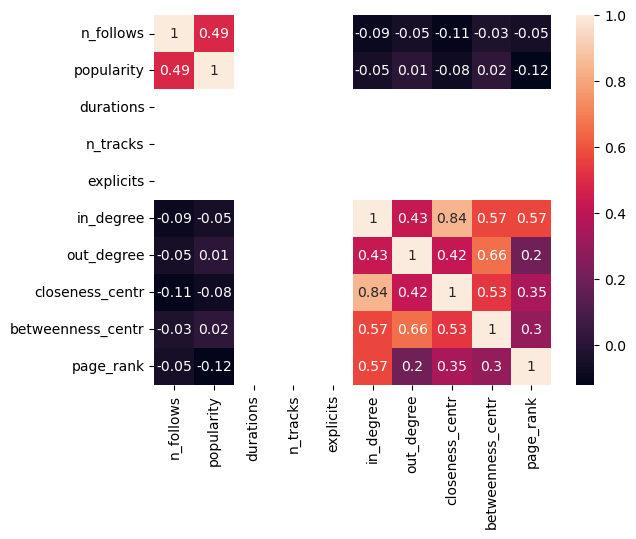

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
matrix = df.corr().round(2)
sns.heatmap(matrix, annot=True)
plt.show()

In [ ]:
# Create a DataFrame from the node attributes dictionary
df = pd.DataFrame.from_dict(node_attributes, orient='index')